In [3]:
# standard libs
import os
import sys
import logging

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..', 'src')
sys.path.append(PROJECT_SRC_PATH)

import utils
import dataset
import visualizations
from prediction_age import AgePredictor, AgeClassifier, AgePredictorComparison
from preprocessing import *

# external libs
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely import wkt

import shap

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from xgboost import XGBRegressor, XGBClassifier, XGBRFClassifier

/usr/local/Caskroom/miniconda/base/envs/uf-ml/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [4]:
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

In [5]:
import warnings
warnings.filterwarnings('ignore', message='pandas.Int64Index is deprecated')
logging.captureWarnings(True)

In [6]:
%load_ext autoreload
%autoreload 2

## Data

In [ ]:
path_data_france = os.path.join('..', 'data', 'france-cities-200.csv')
data_france = pd.read_csv(path_data_france)
data_france_sample = data_france.sample(frac=.1, random_state=dataset.GLOBAL_REPRODUCIBILITY_SEED)

In [ ]:
path_data_netherlands = os.path.join('..', 'data', 'netherlands-cities-200.csv')
data_netherlands = pd.read_csv(path_data_netherlands)
data_netherlands_sample = data_netherlands.sample(frac=.1, random_state=dataset.GLOBAL_REPRODUCIBILITY_SEED)

In [7]:
gdf_nl = utils.load_data('netherlands', geo=False)
gdf_nl_sample = utils.sample_cities(gdf_nl, 0.3)

In [65]:
gdf_fr = pd.read_pickle('../results-concatenate-20220423-195601.pkl')
gdf_fr_sample = utils.sample_cities(gdf_fr, 0.3)
gdf_fr_sample['age'] = gdf_fr_sample['age'].str[:4].astype(float)

2022-04-25 13:14:38,071 | WARNING : 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [8]:
xgb_params_optimal = {
    'max_depth': 10,
    'learning_rate': 0.2,
    'n_estimators': 1000,
    'colsample_bytree': 0.5,
    'subsample': 1.0,
}

## Preprocessing

## Experiments

2022-04-25 09:36:51,472 | INFO : Dataset length: 199622
2022-04-25 09:36:51,639 | INFO : Dataset standard deviation: 37.74490083127791
2022-04-25 09:36:51,644 | INFO : Dataset mean age: 1968.2287773892658
2022-04-25 09:36:51,645 | INFO : Training dataset length: 159697
2022-04-25 09:36:51,645 | INFO : Test dataset length: 39925
2022-04-25 09:36:52,319 | INFO : Test dataset standard deviation after preprocessing: 26.38616596725806
2022-04-25 09:36:52,320 | INFO : Test dataset mean age after preprocessing: 1973.1942647636506
2022-04-25 09:36:52,321 | INFO : Training dataset length after preprocessing: 152884
2022-04-25 09:36:52,322 | INFO : Test dataset length after preprocessing: 38185


MAE: 11.43 y
RMSE: 17.13 y
R2: 0.5786


2022-04-25 09:37:26,051 | WARNING : invalid value encountered in true_divide



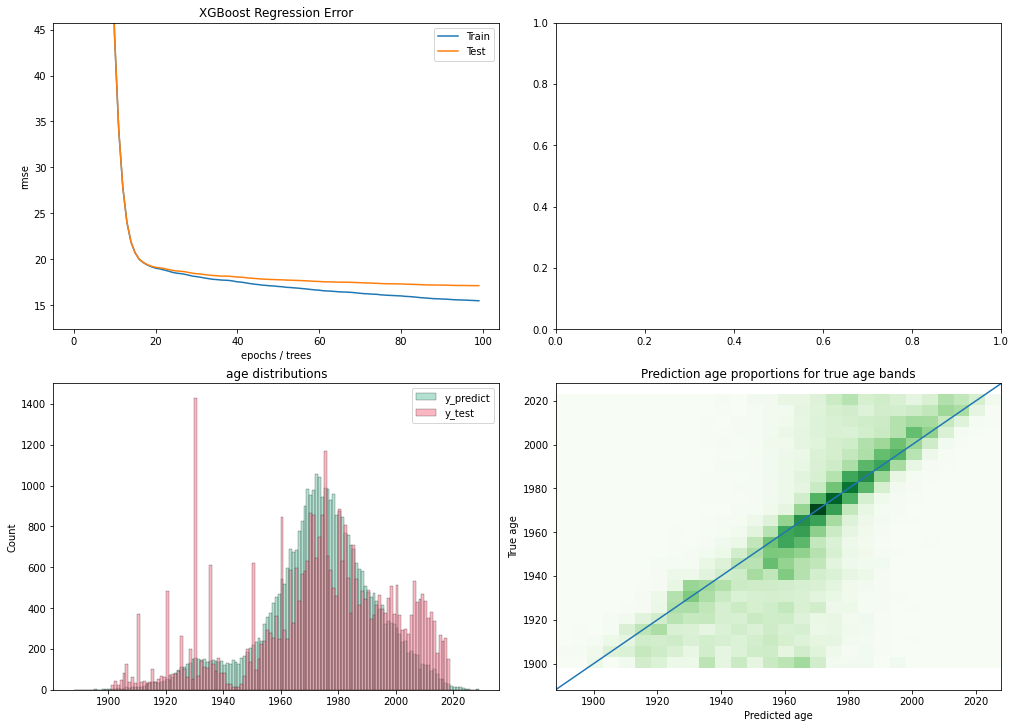

2022-04-25 09:37:27,125 | WARNING : Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<Figure size 432x288 with 0 Axes>

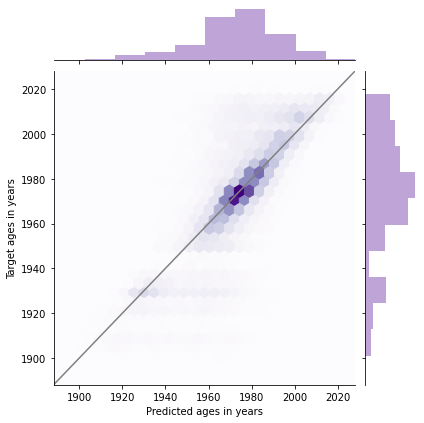

In [9]:
regressor_nl = AgePredictor(
    model=XGBRegressor(),
    df=gdf_nl_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_outliers]
)
regressor_nl.evaluate_regression()

In [20]:
# regressor_nl.save('../data/netherlands_regressor.pkl')
loaded_predictor = AgePredictor.load('../data/netherlands_regressor.pkl')

2022-04-23 19:33:29,222 | INFO : Generated bins: [1900, 1920, 1940, 1960, 1980, 2000, 2020]
2022-04-23 19:33:29,223 | INFO : Generated bins with the following labels: ['1900-1919', '1920-1939', '1940-1959', '1960-1979', '1980-1999', '2000-2019']
2022-04-23 19:33:29,374 | INFO : Dataset length: 199622
2022-04-23 19:33:29,536 | INFO : Training dataset length: 159697
2022-04-23 19:33:29,537 | INFO : Test dataset length: 39925
2022-04-23 19:33:29,841 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2019).
2022-04-23 19:33:29,920 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2019).
2022-04-23 19:33:30,307 | INFO : Training dataset length after preprocessing: 152884
2022-04-23 19:33:30,308 | INFO : Test dataset length after preprocessing: 38185
2022-04-23 20:03:32,099 | WARNING : FixedFormatter should only be used together with FixedLocator



Classification report:
               precision    recall  f1-score   support

   1900-1919       0.74      0.68      0.71      1324
   1920-1939       0.77      0.79      0.78      4412
   1940-1959       0.81      0.78      0.79      3379
   1960-1979       0.86      0.88      0.87     12459
   1980-1999       0.85      0.84      0.85     10028
   2000-2019       0.79      0.78      0.79      6583

    accuracy                           0.83     38185
   macro avg       0.80      0.79      0.80     38185
weighted avg       0.83      0.83      0.83     38185

Cohen’s kappa: 0.7761
Matthews correlation coefficient (MCC): 0.7762


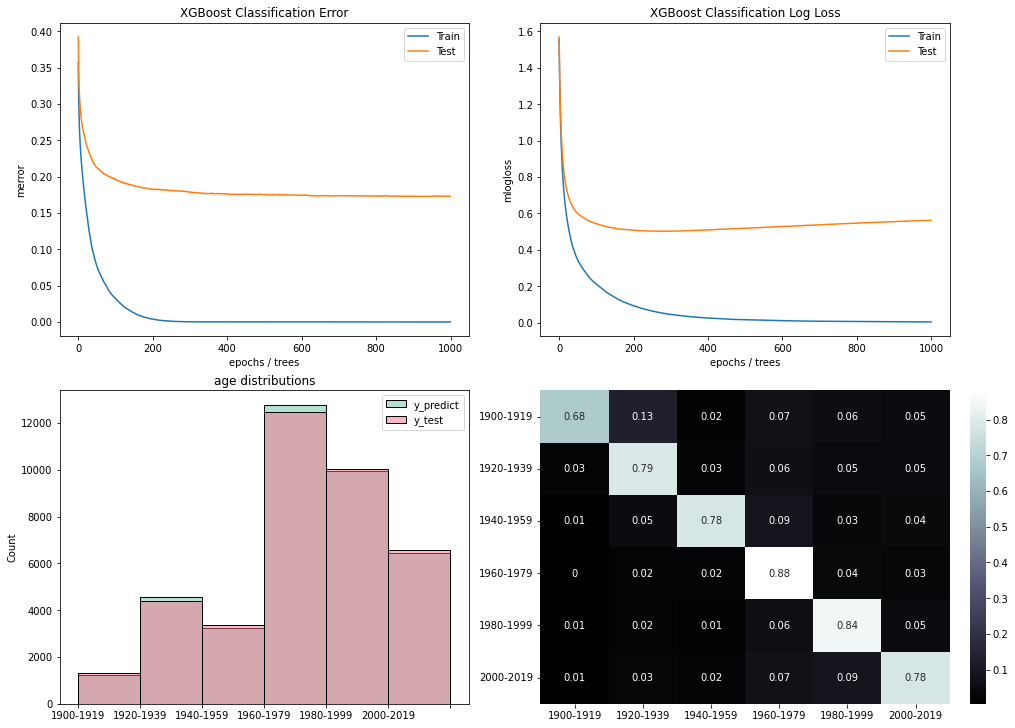

In [88]:
classifier_nl_tuned = AgeClassifier(
    model=XGBClassifier(),
    df=gdf_nl_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_outliers],
    mitigate_class_imbalance=True,
    hyperparameters=xgb_params_optimal,
    bin_config=(1900, 2020, 20),
)
classifier_nl_tuned.evaluate_classification()

2022-04-23 20:03:33,411 | INFO : Generated bins: [1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020]
2022-04-23 20:03:33,412 | INFO : Generated bins with the following labels: ['1900-1904', '1905-1909', '1910-1914', '1915-1919', '1920-1924', '1925-1929', '1930-1934', '1935-1939', '1940-1944', '1945-1949', '1950-1954', '1955-1959', '1960-1964', '1965-1969', '1970-1974', '1975-1979', '1980-1984', '1985-1989', '1990-1994', '1995-1999', '2000-2004', '2005-2009', '2010-2014', '2015-2019']
2022-04-23 20:03:33,641 | INFO : Dataset length: 199622
2022-04-23 20:03:33,783 | INFO : Training dataset length: 159697
2022-04-23 20:03:33,784 | INFO : Test dataset length: 39925
2022-04-23 20:03:34,010 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2019).
2022-04-23 20:03:34,087 | INFO : age attribute has been categorized (lowest age included: 1900; highest ag

Classification report:
               precision    recall  f1-score   support

   1900-1904       0.70      0.54      0.61       136
   1905-1909       0.68      0.60      0.64       343
   1910-1914       0.62      0.59      0.60       518
   1915-1919       0.82      0.69      0.75       327
   1920-1924       0.65      0.65      0.65       801
   1925-1929       0.65      0.53      0.58       681
   1930-1934       0.66      0.73      0.69      1857
   1935-1939       0.72      0.68      0.70      1073
   1940-1944       0.63      0.50      0.56       165
   1945-1949       0.80      0.72      0.76       449
   1950-1954       0.71      0.73      0.72      1331
   1955-1959       0.81      0.78      0.80      1434
   1960-1964       0.72      0.75      0.74      2302
   1965-1969       0.79      0.82      0.81      2814
   1970-1974       0.82      0.84      0.83      3973
   1975-1979       0.80      0.83      0.82      3370
   1980-1984       0.82      0.83      0.83      3247
   

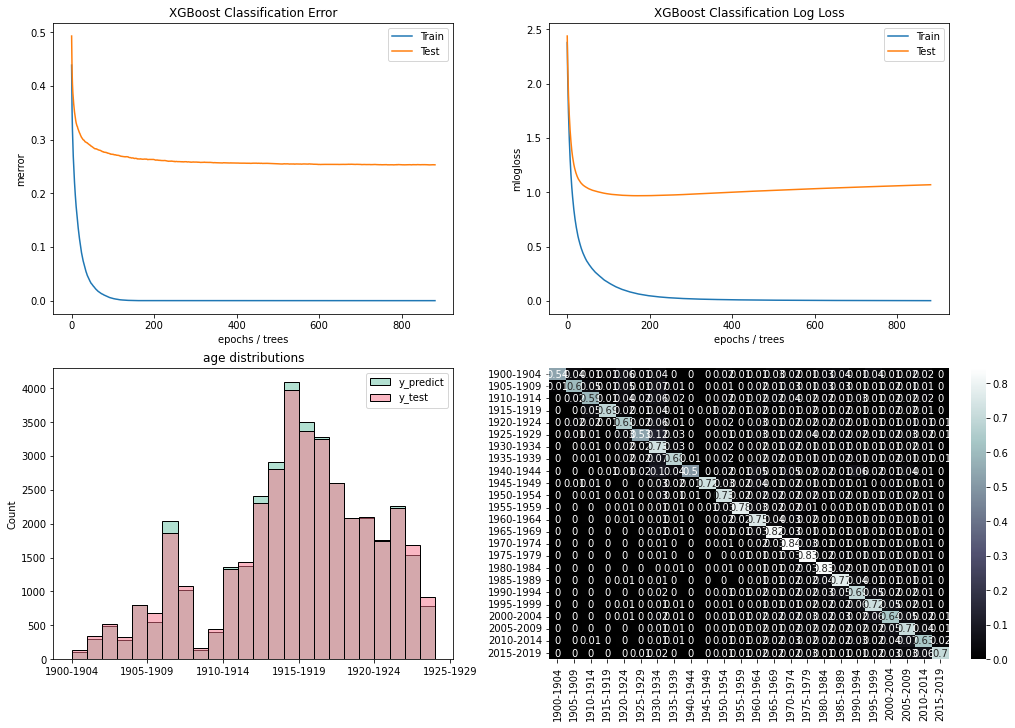

In [89]:
classifier_nl_small_bins = AgeClassifier(
    model=XGBClassifier(),
    df=gdf_nl_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_outliers],
    # mitigate_class_imbalance=True,
    hyperparameters=xgb_params_optimal,
    bin_config=(1900, 2020, 5),
)
classifier_nl_small_bins.evaluate_classification()

In [63]:
gdf_fr_sample['age']

0                 NaN
1          1992-01-01
2                 NaN
3                 NaN
4                 NaN
              ...    
2510903           NaN
2510904           NaN
2510905           NaN
2510906           NaN
2510907           NaN
Name: age, Length: 957013, dtype: object

2022-04-25 13:14:47,416 | INFO : Generated bins: [1900, 1920, 1940, 1960, 1980, 2000, 2020]
2022-04-25 13:14:47,417 | INFO : Generated bins with the following labels: ['1900-1919', '1920-1939', '1940-1959', '1960-1979', '1980-1999', '2000-2019']
2022-04-25 13:14:48,159 | INFO : Dataset length: 401916
2022-04-25 13:14:48,594 | INFO : Training dataset length: 321532
2022-04-25 13:14:48,597 | INFO : Test dataset length: 80384
2022-04-25 13:14:49,388 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2019).
2022-04-25 13:14:49,629 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2019).
2022-04-25 13:14:50,328 | INFO : Training dataset length after preprocessing: 237354
2022-04-25 13:14:50,328 | INFO : Test dataset length after preprocessing: 59568
2022-04-25 13:20:27,451 | WARNING : FixedFormatter should only be used together with FixedLocator



Classification report:
               precision    recall  f1-score   support

   1900-1919       0.38      0.66      0.49      3095
   1920-1939       0.56      0.58      0.57      8444
   1940-1959       0.56      0.57      0.57      7522
   1960-1979       0.65      0.53      0.58     14762
   1980-1999       0.63      0.58      0.60     14150
   2000-2019       0.60      0.66      0.63     11595

    accuracy                           0.59     59568
   macro avg       0.56      0.60      0.57     59568
weighted avg       0.60      0.59      0.59     59568

Cohen’s kappa: 0.4925
Matthews correlation coefficient (MCC): 0.4939


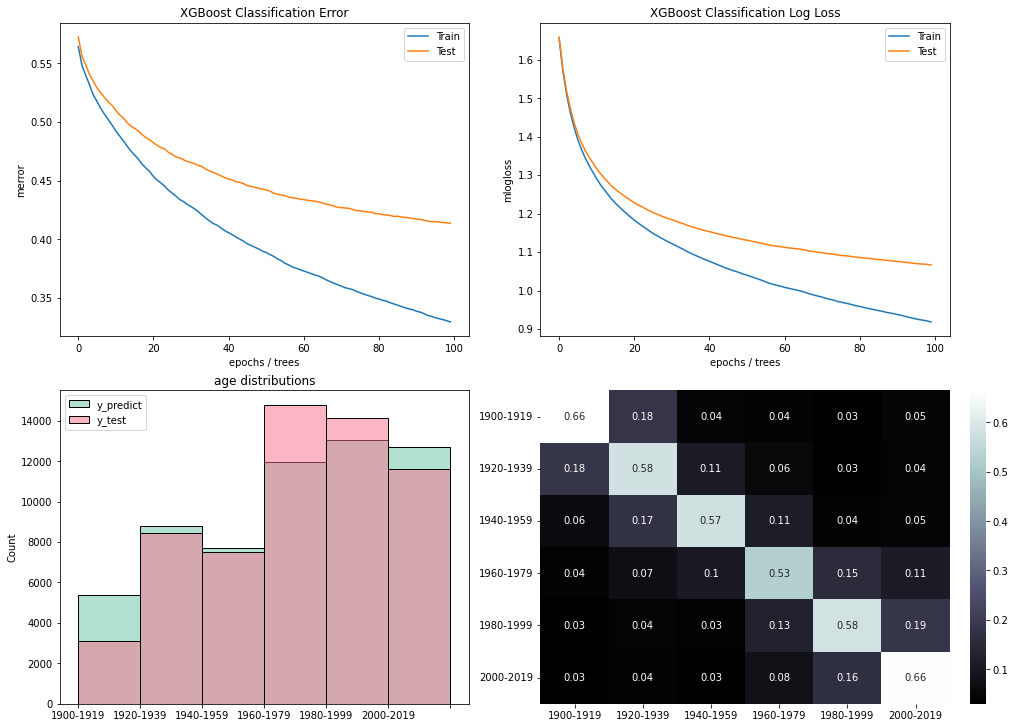

In [66]:
classifier_fr = AgeClassifier(
    model=XGBClassifier(),
    df=gdf_fr_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_outliers],
    mitigate_class_imbalance=True,
    # hyperparameters=xgb_params_optimal,
    bin_config=(1900, 2020, 20),
)
classifier_fr.evaluate_classification()

2022-04-23 10:42:08,922 | INFO : Generated bins: [1900, 1920, 1940, 1960, 1980, 2000, 2020]
2022-04-23 10:42:08,923 | INFO : Generated bins with the following labels: ['1900-1919', '1920-1939', '1940-1959', '1960-1979', '1980-1999', '2000-2019']
2022-04-23 10:42:09,166 | INFO : Dataset length: 199622
2022-04-23 10:42:09,307 | INFO : Training dataset length: 159697
2022-04-23 10:42:09,308 | INFO : Test dataset length: 39925
2022-04-23 10:42:09,663 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2019).
2022-04-23 10:42:09,696 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2019).
2022-04-23 10:42:10,066 | INFO : Training dataset length after preprocessing: 152884
2022-04-23 10:42:10,067 | INFO : Test dataset length after preprocessing: 38185
2022-04-23 10:45:30,551 | WARNING : FixedFormatter should only be used together with FixedLocator



Classification report:
               precision    recall  f1-score   support

   1900-1919       0.39      0.78      0.52      1324
   1920-1939       0.63      0.75      0.68      4412
   1940-1959       0.60      0.78      0.68      3379
   1960-1979       0.90      0.75      0.82     12459
   1980-1999       0.86      0.75      0.80     10028
   2000-2019       0.72      0.73      0.73      6583

    accuracy                           0.75     38185
   macro avg       0.68      0.76      0.70     38185
weighted avg       0.78      0.75      0.76     38185

Cohen’s kappa: 0.6854
Matthews correlation coefficient (MCC): 0.6883


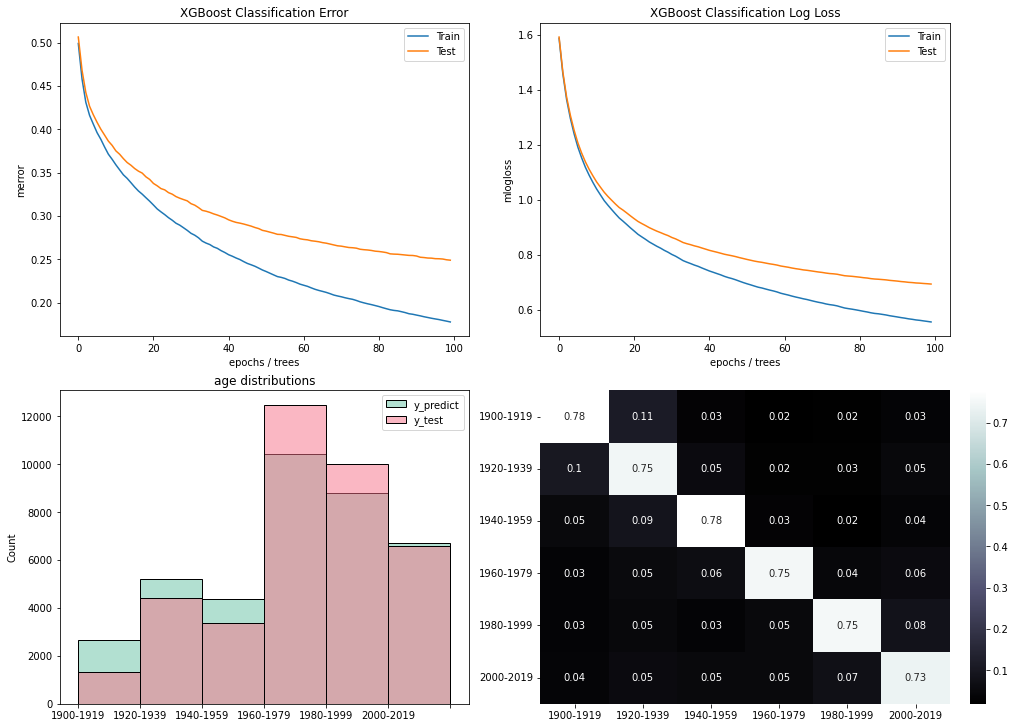

In [9]:
classifier_nl = AgeClassifier(
    model=XGBClassifier(),
    df=gdf_nl_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_outliers],
    mitigate_class_imbalance=True,
    # hyperparameters=xgb_params_optimal,
    bin_config=(1900, 2020, 20),
)
classifier_nl.evaluate_classification()

2022-04-23 18:49:13,064 | INFO : Generated bins: [0, 1965, 1975, 1992, 2006, 2015, inf]
2022-04-23 18:49:13,065 | INFO : Generated bins with the following labels: ['<1965', '1965-1974', '1975-1991', '1992-2005', '2006-2014', '>=2015']
2022-04-23 18:49:13,233 | INFO : Dataset length: 199622
2022-04-23 18:49:13,402 | INFO : Training dataset length: 159697
2022-04-23 18:49:13,403 | INFO : Test dataset length: 39925
2022-04-23 18:49:13,688 | INFO : age attribute has been categorized (lowest age included: 0; highest age included: inf).
2022-04-23 18:49:13,762 | INFO : age attribute has been categorized (lowest age included: 0; highest age included: inf).
2022-04-23 18:49:14,118 | INFO : Training dataset length after preprocessing: 152884
2022-04-23 18:49:14,119 | INFO : Test dataset length after preprocessing: 38185
2022-04-23 18:52:31,611 | WARNING : FixedFormatter should only be used together with FixedLocator



Classification report:
               precision    recall  f1-score   support

       <1965       0.79      0.82      0.81     11417
   1965-1974       0.82      0.78      0.80      6787
   1975-1991       0.89      0.73      0.80     10048
   1992-2005       0.68      0.71      0.69      5461
   2006-2014       0.62      0.69      0.65      3561
      >=2015       0.37      0.77      0.50       911

    accuracy                           0.76     38185
   macro avg       0.69      0.75      0.71     38185
weighted avg       0.78      0.76      0.77     38185

Cohen’s kappa: 0.6973
Matthews correlation coefficient (MCC): 0.6987


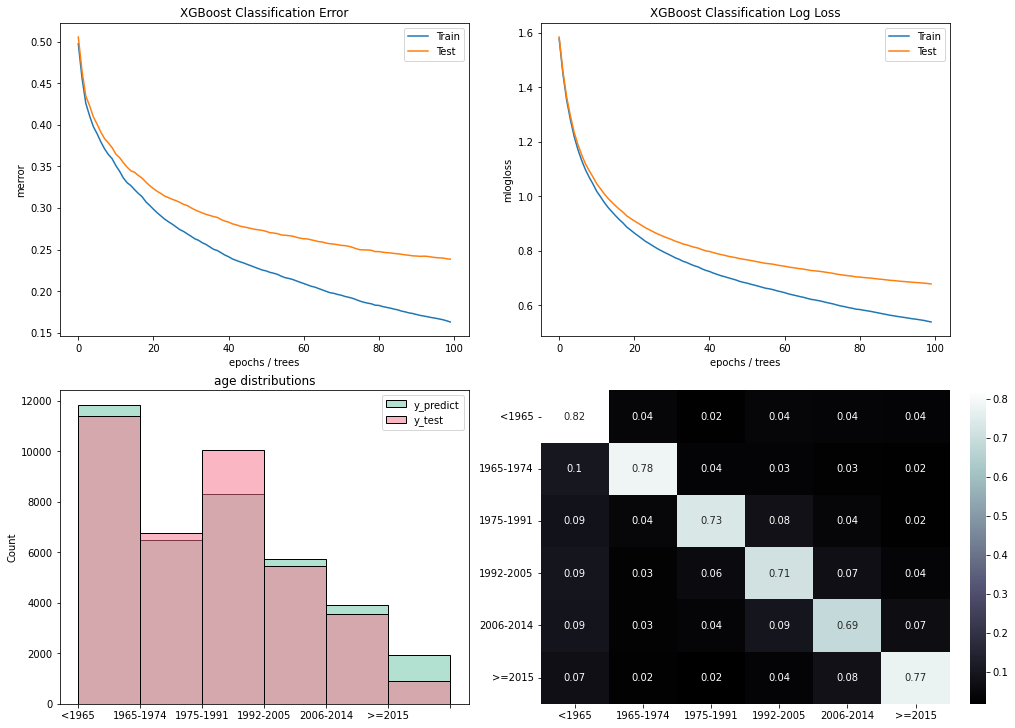

In [70]:
classifier_nl_tabula = AgeClassifier(
    model=XGBClassifier(),
    df=gdf_nl_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_outliers],
    mitigate_class_imbalance=True,
    # hyperparameters=xgb_params_optimal,
    bins=tabula_nl_bins,
)
classifier_nl_tabula.evaluate_classification()

In [80]:
tabula_nl_bins = [1900, 1965, 1975, 1992, 2006, 2015, 2022]

In [100]:
def mean_bin_age(s, bins):
    cat_to_metric = {idx: (bins[idx] + bins[idx+1]) / 2 for idx in range(len(bins) - 1)}
    return s.map(cat_to_metric)

def rmse(y_test, y_predict):
    return np.sqrt(metrics.mean_squared_error(y_test, y_predict))

def mae(y_test, y_predict):
    return metrics.mean_absolute_error(y_test, y_predict)

def r2(y_test, y_predict):
    return metrics.r2_score(y_test, y_predict)

# bins = tabula_nl_bins
bins = utils.generate_bins(bin_config=(1900, 2020, 5))
for classifier in [classifier_nl_small_bins]:
    y_test_metric = classifier.aux_vars_test[classifier.metric_target_attribute]
    y_predict_metric = mean_bin_age(classifier.y_predict[classifier.target_attribute], bins)
    print(rmse(y_test_metric, y_predict_metric))
    print(mae(y_test_metric, y_predict_metric))
    print(r2(y_test_metric, y_predict_metric))

17.530408866878638
7.634529265418358
0.5585892712177847


In [85]:
from sklearn import metrics
import preprocessing

def classification_report_for_regression(y_test, y_predict, bins=[], bin_config=None):
    bins = bins or utils.generate_bins(bin_config)
    labels = utils.generate_labels(bins)
    y_test_cat = preprocessing.categorize_age(y_test, bins=bins, remove_outliers=False)
    y_predict_cat = preprocessing.categorize_age(y_predict, bins=bins, remove_outliers=False)
    labels.insert(0, 'Outlier')
    # print(metrics.classification_report(y_test_cat, y_predict_cat[[dataset.AGE_ATTRIBUTE]], target_names=labels))
    print(metrics.matthews_corrcoef(y_test_cat, y_predict_cat[[dataset.AGE_ATTRIBUTE]]))
    print(metrics.cohen_kappa_score(y_test_cat, y_predict_cat[[dataset.AGE_ATTRIBUTE]]))

classification_report_for_regression(regressor_nl.y_test.copy(), regressor_nl.y_predict.copy(), bin_config=(1900, 2020, 20))
classification_report_for_regression(regressor_nl.y_test.copy(), regressor_nl.y_predict.copy(), bins=tabula_nl_bins)

2022-04-23 19:21:09,134 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2019).
2022-04-23 19:21:09,138 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2019).
2022-04-23 19:21:09,173 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2022-04-23 19:21:09,176 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).


0.429699714268837
0.4207802162865184
0.43418612769336135
0.4301133940974974


In [31]:
gdf_fr.type_source.dropna()

0                Sportif
1                Sportif
2                Sportif
3          Indifférencié
4          Indifférencié
               ...      
2531698         Agricole
2531699         Agricole
2531700         Agricole
2531701         Agricole
2531702         Agricole
Name: type_source, Length: 2167280, dtype: object

In [55]:
tabula_years = pd.read_csv('../metadata/tabula_years.csv')
tabula_years = tabula_years[tabula_years['Country'].isin(['France', 'Netherlands'])]
tabula_combined_bins = sorted(tabula_years['Age'][~tabula_years['Age'].str.contains('<')].str[:4].unique())
tabula_combined_bins

['1915',
 '1949',
 '1965',
 '1968',
 '1975',
 '1982',
 '1990',
 '1992',
 '2000',
 '2006',
 '2013',
 '2015']